In [58]:
import argparse
import cv2
from cv2 import GaussianBlur
from data import AvirisDataset
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import rasterio
import torch
from model import TwoBranchCNN
from types import SimpleNamespace

In [47]:
with open('hist_loss.json','r') as file:
    hist_loss = json.load(file)

In [48]:
hist_train_loss = hist_loss['hist_loss']
hist_val_loss = hist_loss['hist_val_loss']

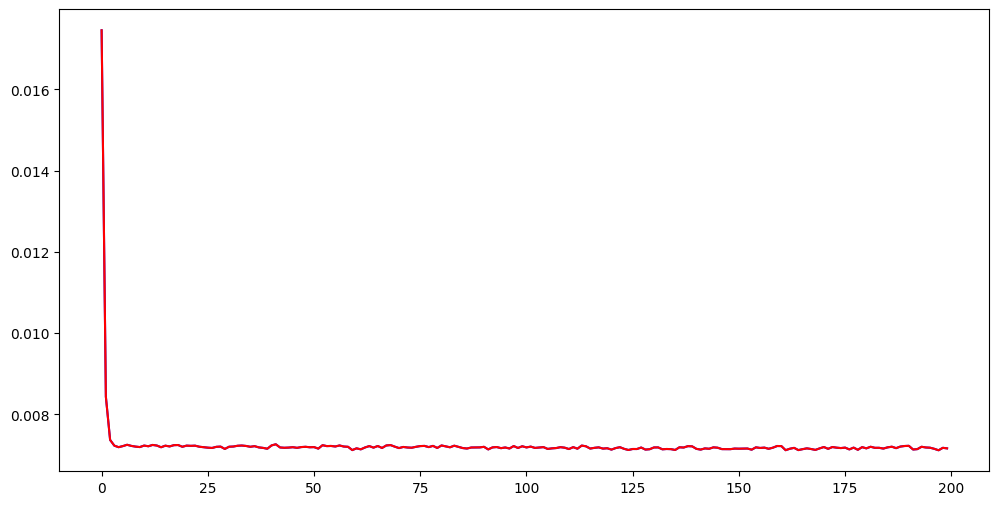

In [50]:
plt.figure(figsize=(12,6))
plt.plot(range(len(hist_train_loss)),hist_train_loss, c='b')
plt.plot(range(len(hist_val_loss)),hist_train_loss, c='r')


In [9]:
def load_checkpoint(model, optimizer=None, scheduler=None, path=None, device='cpu'):
    """
    Loads model, optimizer, and scheduler states from a checkpoint file.

    Parameters:
        model (torch.nn.Module): Model instance to load weights into.
        optimizer (torch.optim.Optimizer, optional): Optimizer instance.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler instance.
        path (str): Path to the checkpoint file.
        device (str or torch.device): Device to map the checkpoint to.

    Returns:
        model (torch.nn.Module): Model with loaded weights.
        optimizer (torch.optim.Optimizer, optional): Optimizer with loaded state (if provided).
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler with loaded state (if provided).
        start_epoch (int): Epoch to resume training from.
    """
    if path is None:
        raise ValueError("Checkpoint path must be provided.")

    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'], strict=False)
    
    start_epoch = checkpoint.get('epoch', 0) + 1

    if optimizer and 'optimizer' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer'])

    if scheduler and 'scheduler' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler'])

    print(f"Loaded checkpoint from {path}, resuming at epoch {start_epoch}")
    return model, optimizer, scheduler, start_epoch

In [51]:
# Load trained model

TBCNN = TwoBranchCNN()
model_path = os.path.join('runs','best_epoch019_0.0078.pt')
print(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TBCNN, _, _, _ = load_checkpoint(TBCNN, path=model_path, device=device )

size of input layer of FC 2320
runs/best_epoch019_0.0078.pt
Loaded checkpoint from runs/best_epoch019_0.0078.pt, resuming at epoch 20


In [52]:
@torch.no_grad()
def predict(model, patch, spectrum, device):
    patch = torch.tensor(patch).to(device)
    spectrum = torch.tensor(patch).to(device)
    pred = model(patch, spectrum)
    return pred

In [ ]:
# Fonction qui calcule l'image prédite : prendre en entrée MSI/HSI, upscaler HSI, boucler sur i et j, appeler le modèle, prédire le spectre, remplir le cube de sortie
def build_image(model: torch.nn, hsi: np.array, msi: np.array, scale: int, device: torch.cuda.device) -> np.array:
    H, W = msi.shape[:2]
    C = hsi.shape[2]
    hrhsi = np.array((H,W,C))
    # upscaled_hsi = model.upscale_hyperspectral(hsi, method='bicubic')
    # offset = (model.patch_size - 1)
    offset = (31 - 1) #temporary
    for i in range(offset, H - offset):
        for j in range(offset,W - offset):
            current_patch_msi = msi[i:i+model.patch_size,j:j+model.patch_size]
            current_spectrum_hsi = upscaled_hsi[i+offset,j+offset]
            hrhsi[i,j] = predict(model, current_patch_msi,current_spectrum_hsi,device)
    return hrhsi 

#### Get dataset for tests

In [ ]:
def get_args():
    p = argparse.ArgumentParser(description="Two-branch CNN training")
    # data / io
    p.add_argument("--image_path", type=str, default="/mnt/c/data/AVIRIS/",help="Root directory that contains AVIRIS scenes")    
    p.add_argument("--srf_path", type=str,default="srf/Landsat8_BGRI_SRF.xls",help="Spectral response file (xls)")
    p.add_argument('--image_number', type=int, default=2)
    p.add_argument("--results_dir", type=str, default="runs",help="Where to store checkpoints & logs")
    # training hyper-params
    p.add_argument("--epochs", type=int, default=200)
    p.add_argument("--batch_size", type=int, default=128)
    p.add_argument("--lr", type=float, default=1e-4)
    p.add_argument("--step_size", type=int, default=100,
                   help="LR scheduler step")
    p.add_argument("--gamma", type=float, default=0.1,
                   help="LR decay factor")
    p.add_argument("--seed", type=int, default=3407)
    # data specifics
    p.add_argument("--patch_size", type=int, default=31)
    p.add_argument("--stride", type=int, default=31)
    p.add_argument("--training_ratio", type=float, default=0.7)
    p.add_argument('--scale', type=int, default=2)
    p.add_argument('--hsi_bands', type=int, default=224)   
    p.add_argument('--msi_bands', type=int, default=4)  
    p.add_argument('--num_workers', type=int, default=4)
    p.add_argument('--optimizer', type=str, default='Adam')
    p.add_argument('--upscale_hsi', type=str, default=True)
    
    return p.parse_args()



In [56]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
args = SimpleNamespace(
    image_path='/mnt/c/data/AVIRIS/',
    srf_path="srf/Landsat8_BGRI_SRF.xls",
    image_number=2,
    seed=3407,
    patch_size=31,
    scale=2,
    train_mode=False,
    training_ratio=0.7,
    stride=31
)

In [70]:
# Use Aviris Dataset class and tools
set_seed(args.seed)
dataset = AvirisDataset(args=args, device=device)

Low resolution 15
Number of tiles 2
Reading HS data from /mnt/c/data/AVIRIS/f111116t01p00r19/f111116t01p00r19rdn_c/f111116t01p00r19rdn_c_sc01_ort_img
Shape of hyperspectral data: (224, 2799, 1076)
Number of bands: 224
global min and max -50, 32455
Number of patches 3060


100%|██████████| 3060/3060 [00:53<00:00, 57.06it/s] 


Reading HS data from /mnt/c/data/AVIRIS/f111116t01p00r20/f111116t01p00r20rdn_c/f111116t01p00r20rdn_c_sc01_ort_img
Shape of hyperspectral data: (224, 2389, 1047)
Number of bands: 224
global min and max -50, 32457
Number of patches 2541


100%|██████████| 2541/2541 [00:28<00:00, 89.69it/s] 


Dataset built
Dataset loaded as tensors


In [75]:
dataset.GT_list[78]

array([0.01990463, 0.02196585, 0.02430395, 0.03141055, 0.04408553,
       0.04617751, 0.04430088, 0.04371635, 0.04891555, 0.05109983,
       0.05131518, 0.04971543, 0.04876173, 0.04706968, 0.04630057,
       0.04503922, 0.04383941, 0.04423935, 0.04460852, 0.04451623,
       0.04368559, 0.04260883, 0.04282418, 0.04131672, 0.04156284,
       0.0415936 , 0.04067067, 0.03940932, 0.03980926, 0.03860944,
       0.03780957, 0.03922473, 0.03796339, 0.03913244, 0.03836333,
       0.034487  , 0.03356407, 0.03488694, 0.0321489 , 0.02796493,
       0.03128749, 0.03442547, 0.03331795, 0.02064298, 0.03131826,
       0.03291801, 0.03122597, 0.03021074, 0.02734964, 0.02341178,
       0.02485771, 0.02722658, 0.02750346, 0.02716505, 0.02682664,
       0.02639594, 0.02516536, 0.02005845, 0.01765882, 0.01673589,
       0.01445931, 0.00766036, 0.00747577, 0.00984464, 0.01544378,
       0.01741271, 0.02061221, 0.0213198 , 0.02085833, 0.02091986,
       0.02055068, 0.02018151, 0.01981234, 0.01910475, 0.01839

In [72]:
test_hrhsi = dataset.GT_list[0]
test_hrmsi = dataset.HRMSI_list[0]
test_lrhsi = dataset.LRHSI_list[0]

In [76]:
test_lrhsi.shape

(224,)

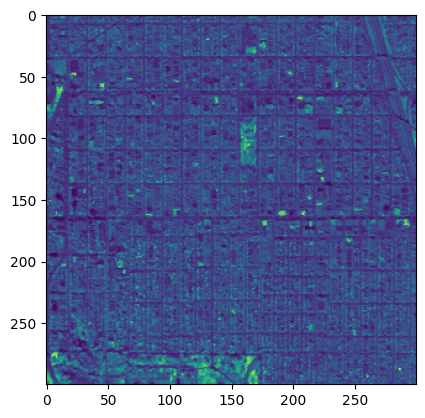

In [32]:
plt.imshow(test_hrhsi[:,:,55])

In [ ]:
def make_hsi(img, sigma,):
    # Gaussian blur, 3x3 kernel, then scale reduction
    blurred_hs = GaussianBlur(img,(3,3),sigmaX=sigma, borderType=0)
    blurred_hs_normalized = np.empty(blurred_hs.shape, dtype=blurred_hs.dtype)
    # Normalization by channel - Global normalization?
    for j in range(len(self.wavelengths)):
        blurred_hs_normalized[:,:,j] = cv2.normalize(blurred_hs[:,:,j],None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # Downsampling    
    lr_hsi =cv2.resize(blurred_hs_normalized,(self.subres,self.subres),interpolation=cv2.INTER_NEAREST)
    return lr_hsi

In [ ]:
test_hrmsi = TBCNN.make

In [ ]:
build_image(TBCNN,)